# First let's examine our data:

* train/test folder: list of files where each file contains values of (up to) 10 sensors containing the read value from that sensor of 10 minutes sampling.
    * Numbers are normalized to int16. 
* train.csv: List of pairs of:
     * segment id: train file id number
     * eruption time: The target value, the time until the next eruption.
* sample_submission.csv: same as train.csv but for the test dataset
    * This file is empty -> we are responsible to fill it up using the system we create.


# Describing the data

Each data item can be interpreted as such:
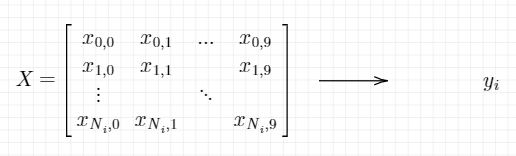
* The input is [$N_i \times 10$] matrix of sensors readings.
* The output is the eruption time.
    * $ x_{i,j} $ Represents the i’th reading of sensor j.
* There are M items as such in the dataset.
* $ M = 10 (min) * 60 (secs) * 100 (csecs) = 60,000 samples $


lets add some classes and methods for later usage:

## imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
# from scipy import signal
import seaborn as sns

## classes & methods

In [ ]:
# =============================== constants ===============================


class C:

    data_path = '../input/predict-volcanic-eruptions-ingv-oe/'
    col_name_index = "segment_id"
    col_name_target = "time_to_eruption"
    col_name_sensor = "sensor_"
    N_sensors = 10
    N_samples = 60000  # in hundredths of seconds
    N_length_in_csec = 60000
    N_length_in_sec = 600
    N_length_in_min = 10


# =============================== data methods ===============================


class Data_Methods:
    @staticmethod
    def fetch_matrix(dataset, i_data):
        matrix = np.zeros([C.N_samples + 1, C.N_sensors])
        data_i = dataset.get_x_i(i_data)
        for i in range(0, C.N_sensors):
            sens_col = "%s%d" % (C.col_name_sensor, i + 1)
            matrix[:, i] = data_i[sens_col]

        return matrix

    @staticmethod
    def create_time_vec(num_samples=C.N_samples, units="min"):
        if units == "min":
            times = np.linspace(0, C.N_length_in_min, num_samples + 1)
        elif units == "sec":
            times = np.linspace(0, C.N_length_in_sec, num_samples + 1)
        else:
            exit("please choose units for time vec, either min or sec")
            times = []

        return times

    @staticmethod
    def validate_set_type(set_type):
        if set_type == 'train' or set_type == 'test':
            return set_type
        else:
            exit('please choose appropriate data set type, either "train" or "test"')


class Dataset():
    def __init__(self, path=C.data_path, set_type='train'):
        self.base_path = path
        self.set_type = Data_Methods.validate_set_type(set_type)
        # self.X_ids, self.targets = self.fetch_targets()

        # def fetch_targets(self):
        # read train.csv returns panda format of [x->y] pairs

        if self.set_type == 'train':
            full_path = self.base_path + 'train.csv'
        else:
            exit("TODO: #0001")  # TODO #0001
            full_path = []
        try:
            data = pd.read_csv(full_path)
        except Exception:
            exit('train.csv is not located at: ' + self.base_path)
            data = None
        self.X_ids = data[C.col_name_index]
        self.targets = data[C.col_name_target]

    def get_x_i(self, i_data):
        # read <names[i_data]>.csv from train/test folder
        # returns panda format of matrix X[0:60,000,0:10]
        try:
            file_name = self.X_ids[i_data]
            full_path = self.base_path + '%s/%d' % (self.set_type, file_name) + '.csv'
            data = pd.read_csv(full_path)
            return data
        except Exception:
            exit('could not find at %s folder the file #%d' % (self.set_type, i_data))

    def fetch_vector(self, i_data, i_sensor):
        X_matrix_i = self.get_x_i(i_data)
        vec = self.x_matrix_to_vec(X_matrix_i,i_sensor)
        return vec

    def x_matrix_to_vec(self, X_matrix, i_sensor):
        sens_col = "%s%d" % (C.col_name_sensor, (i_sensor + 1))
        vec = X_matrix[sens_col]
        return vec

    def get_y(self):
        return self.targets

    def get_x_i_name(self, i):
        # returns the name of the file for the i'th file
        return self.X_ids[i]

# =============================== Math methods ===============================
    

class Math_Methods:

    @staticmethod
    def divide_to_square(N):
        # splitting N into N1 and N2 such that:
        # N1*N2 = N
        # N1,N2 are integers
        # N1,N2 are close to each other as possible
        # designated mostly for square'ish subplot N vectors.

        fs = Math_Methods.factors(N)
        N1, N2 = fs[-1]

        return int(N1), int(N2)

    @staticmethod
    def factors(N):
        factors = []
        for i in range(1, int(N ** 0.5) + 1):
            if N % i == 0:
                factors.append((i, N / i))
        return factors

    @staticmethod
    def convert_cs_to_min(cs):
        return cs/100/60

    @staticmethod
    def generate_spectrogram(signal_t):
        fc = C.N_samples / C.N_length_in_sec # sampling frequency
        freqs, times, spectrogram = signal.spectrogram(signal_t, fc)
        return freqs, times, spectrogram    
    
# =============================== UI methods ===============================

class UI_Methods:

    @staticmethod
    def plot_vec(y, x=None, xlabel='', ylabel='', title=''):
        plt.figure()
        if x is None:
            plt.plot(y)
        else:
            plt.plot(x, y)

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_vec_with_line(y, x, line_x, xlabel='', ylabel='', title=''):
        plt.figure()

        plt.plot(x, y)
        plt.axvline(x=line_x, color='r')

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.grid(True)
        plt.show()

    @staticmethod
    def plot_sensor(sensor_values, sensor_index, data_index):
        times = methods_data.Data_Methods.create_time_vec(units="min")

        UI_Methods.plot_vec(sensor_values, times,
                            xlabel='t[min]',
                            ylabel='sensor value',
                            title='sensor[%d] of sample[%d] over time' % (sensor_index, data_index))

    @staticmethod
    def plot_sensor_with_timestamp(sensor_values, sensor_index, data_index, timestamp):
        times = methods_data.Data_Methods.create_time_vec(units="min")
        x_line = times[int(timestamp)]

        volcano_time = UI_Methods.timestamp_to_time(timestamp)
        UI_Methods.plot_vec_with_line(sensor_values, times, x_line,
                                      xlabel='t[min]',
                                      ylabel='sensor value',
                                      title='sensor[%d] of sample[%d], volcano@%s' % (sensor_index, data_index, volcano_time))

    @staticmethod
    def subplot_all_sensors(y_array, data_index, timestamp = None):
        # plot N vectors in subplot form,
        # make sure y's in y_array are columns
        # also make sure y_array is numpy matrix

        xlabel = 't[min]'
        ylabel = 'sensor value'
        super_title = 'sensors of sample[%d] over time' % data_index
        subtitle = 'sensor_'

        x = methods_data.Data_Methods.create_time_vec(units="min")

        [N, M] = y_array.shape
        if len(x) != N:
            exit('when using plot_multiple vecs, make sure y_array is column wise vectors')

        fig, axs = plt.subplots(M, 1, figsize = (12, M))

        for i in range(M):
            index = i
            y = y_array[:, index]
            axs[i].plot(x, y)
            if timestamp is not None:
                axs[i].axvline(x=x[timestamp], color='r')

            axs[i].grid(True)
            # axs[i].set_title(subtitle + "%d" % index)
            # axs[i].set_ylabel(ylabel)
        axs[M - 1].set_xlabel(xlabel)
        fig.suptitle(super_title)
        fig.show()

    @staticmethod
    def plot_spectrogram(times, freqs, spectrogram):
        plt.pcolormesh(times, freqs, spectrogram)
        plt.imshow(spectrogram)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()

    @staticmethod
    def timestamp_to_time(timestamp):
        cs = timestamp % 100
        sec = (timestamp // 100) % 60
        min = (timestamp // (60 * 100)) % 60
        hrs = timestamp // (60 * 60 * 100)

        str = '%02d:%02d:%02d.%02d' % (hrs, min, sec, cs)
        return str
    
    @staticmethod
    def plot_hist(vec):
        # calculating freedman-Diaconis's bin value:
        q25, q75 = np.percentile(vec, [.25, .75])
        bin_width = 2 * (q75 - q25) * len(vec) ** (-1 / 3)
        bins = round((vec.max() - vec.min()) / bin_width)
        bins= 2035

        plt.hist(vec, density=True, bins=bins)  # density=False would make counts
        plt.ylabel('Probability')
        plt.xlabel('Data')
        plt.show()

## translation from pycharm to notebook:

In [ ]:
class methods_data:
    Data_Methods = Data_Methods
    Dataset = Dataset
    
class methods_UI:
    UI_Methods = UI_Methods
class methods_math:
    Math_Methods = Math_Methods
C.data_path = '../input/predict-volcanic-eruptions-ingv-oe/'


# Examine the data

Let’s take a single column of sensor over time (10 minutes) and see how it behaves:

Lets first load the dataset

In [ ]:
m_data = methods_data.Dataset()

## picture of single sensor values


In [ ]:
def examine_single_sensor(m_data, data_index, sensor_index):
    sensor_values = m_data.fetch_vector(data_index, sensor_index)
    methods_UI.UI_Methods.plot_sensor(sensor_values, sensor_index, data_index)

examine_single_sensor(m_data, 3,5)

very noisy, not much of info here..

## comparing sensor powers
Let's put sensor value ranges next to each other to see their values:

In [ ]:
def plot_box_plots(data):
    sns.set(rc={'figure.figsize':(10,3)})
    ax = sns.boxplot(data=data)

def compare_sensor_values(m_data, data_index):
    x = m_data.get_x_i(data_index)
    plot_box_plots(x)
    print(x.describe())

compare_sensor_values(m_data, 2)

# Examine target values

In [ ]:
y = m_data.get_y()
y_min = y/100/60
y_min.describe()

In [ ]:
ax = sns.boxplot(data=y_min)

as we can see, most of the occurance times of the volcanos occure after more than 10 minutes, which means the occurance time isn't shown on the sensor data


let's check only the data sets where the volcano erupted in the 10 minutes window and see if we can find some intreresting information there:




In [ ]:
def find_volcano_in_data():
    indices = []
    m_data = methods_data.Dataset()
    y = m_data.get_y()
    plot_counter = 0
    for i, y_i in enumerate(y):
        if y_i < C.N_samples:
            x_i_name = m_data.get_x_i_name(i)
            time = methods_UI.UI_Methods.timestamp_to_time(y[i])
            print('the file %s has volcano occurrence at %s' % (x_i_name, time))
            indices.append(i)


    return indices
            
ids = find_volcano_in_data()



# Lets see those sensors:
first lets create printing method:

In [ ]:
def print_sensors(indices):
    m_data = methods_data.Dataset()
    y = m_data.get_y()
    for i, y_i in enumerate(y[indices]):
        sensor_matrix = methods_data.Data_Methods.fetch_matrix(m_data, i)
        methods_UI.UI_Methods.subplot_all_sensors(sensor_matrix, i, y_i)


## lets now check the first 2:

In [ ]:
print_sensors(ids[0:2])

nothing really happens at the eruption time.. maybe another one:

In [ ]:
print_sensors([ids[6]])

hard to tell.. :\

# Lets check spectrograms

In [ ]:
def plot_spectrogram2(vec_t):
    Fs = C.N_samples / C.N_length_in_sec # sampling frequency
    spectrum, freqs, times, im = plt.specgram(vec_t, Fs=Fs)
    N_time_ticks = 10+1
    times_min = ['%.0d'%i for i in np.linspace(0,C.N_length_in_min,N_time_ticks)]
    times_indices = np.linspace(0,C.N_length_in_sec,N_time_ticks)
    plt.xticks(times_indices, times_min)
    plt.xlabel('time [min]')
    plt.ylabel('freq[Hz]')
    plt.set_cmap('jet')
    plt.colorbar()
    
    plt.show()
    
x = m_data.fetch_vector(i_data=0, i_sensor=1)
plot_spectrogram2(x)

# simple fft view

In [ ]:
def examine_fft(i_data, i_sensor):
    m_data = methods_data.Dataset()
    x = m_data.fetch_vector(i_data=0, i_sensor=1)
    N = len(x)
    
    freqs = np.fft.fftfreq(N,C.N_length_in_sec/C.N_length_in_csec)
    Y_jw = np.fft.fft(x)
    Y_dBm = 20*np.log10(np.abs(Y_jw)/N/(1e-3))
    methods_UI.UI_Methods.plot_vec(Y_dBm,freqs,
                                   xlabel="freq[Hz]",
                                   ylabel='sensor power [dBm]',
                                   title='sensor[%d] from data[%d] in freq domain'%(i_sensor,i_data))

    
#     N = C.N_length_in_sec
#     T = N / C.N_length_in_min
#     X_jw = scipy.fftpack.fft(x.to_numpy())
#     freqs = np.linspace(0.0, 1.0 / (2.0 * T), int(N / 2))
#     freqs2 = scipy.fftpack.fftfreq(N)
#     Yf = 2.0 / N * np.abs(X_jw[:N // 2])
#     methods_UI.UI_Methods.plot_vec(Y_dBm2,freqs,
#                                    xlabel='freq[Hz]',
#                                    ylabel='|sensor(f)|',
#                                    title='sensor[%d] from data[%d] in freq domain'%(i_sensor,i_data))


examine_fft(i_data=0,i_sensor=1)

# Lets devide the target values to binary sets using k-means clustering

In [ ]:
from sklearn.cluster import KMeans
y2 = pd.DataFrame(y)
kmeans = KMeans(n_clusters = 10).fit(y2)


In [ ]:
centers = kmeans.cluster_centers_
centers_in_hrs = centers / 60/100/60
np.sort(centers_in_hrs, axis=0)

In [ ]:
# now lets now use those centers and split [x,y] accordingly

